# Reproducing dMn profiles in the Canada Basin

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import pandas as pd
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar

%matplotlib inline

In [2]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800
isize = imax-imin
jsize = jmax-jmin

# model result set:
# folder_202106 = '/data/brogalla/run_storage/ref-spin-up0-202106/'   # Mn run with sinking on
folder_202106 = '/data/brogalla/run_storage/Mn-tuning-202107/ANHA12_spin-up0_20210714-red-hmld/'   # Mn run with sinking on

year  = 2002
month = 7 # August

# colours:
c_dmn = '#fa8742'
c_pmn = '#579cdd'

In [3]:
mask       = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask      = np.array(mask.variables['tmask'])[0,:,imin:imax,jmin:jmax]
land_mask  = np.ma.masked_where((tmask[:,:,:] > 0.1), tmask[:,:,:]) 
e3t        = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]
model_lons = np.array(mask.variables['nav_lon'])
model_lats = np.array(mask.variables['nav_lat'])

In [4]:
ref   = nc.Dataset(f'{folder_202106}ANHA12_EXH006_{year}_monthly.nc',  'r')
lons  = np.array(ref.variables['nav_lon'])
lats  = np.array(ref.variables['nav_lat'])
depth = np.array(ref.variables['deptht'])

In [5]:
def load_data(folder, month):
#    CB2: (507, 383)
#    CB3: (546, 456)
#    CB4: (628, 470)
#     # Region of focus: in central Canada Basin
#     i  = 608; j  = 418;
#     di = 30;  dj = 30;

    CB4_coord = (0,628, 470)
    
    ncf  = nc.Dataset(f'{folder}ANHA12_EXH006_1m_{year}0101_{year}1231_comp_{year}0{month}-{year}0{month}.nc')
#     dmn_sedice = (np.array(ncf.variables['dmnsedice'])[0,i-di:i+di,j-dj:j+dj]*e3t[0,i-di:i+di,j-dj:j+dj]).mean(axis=(0,1))*1e3
#     dmn_atm    = (np.array(ncf.variables['dmnatm'])[0,i-di:i+di,j-dj:j+dj]*e3t[0,i-di:i+di,j-dj:j+dj]).mean(axis=(0,1))*1e3
#     dmn_ice    = (np.array(ncf.variables['dmnice'])[0,i-di:i+di,j-dj:j+dj]*e3t[0,i-di:i+di,j-dj:j+dj]).mean(axis=(0,1))*1e3
    dmn_sedice = np.array(ncf.variables['dmnsedice'])[CB4_coord]
    dmn_atm    = np.array(ncf.variables['dmnatm'])[CB4_coord]
    dmn_ice    = np.array(ncf.variables['dmnice'])[CB4_coord]
    
    print(f'dMn from sediment in ice (moles per meter squared per second): {dmn_sedice*e3t[CB4_coord]*1e3:.2e}')

    # Load results at end of month:
    if month==7:
        results = nc.Dataset(f'{folder}ANHA12_EXH006_5d_{year}0101_{year}1231_ptrc_T_{year}0{month}25-{year}0{month}29.nc')
    elif month==8:
        results = nc.Dataset(f'{folder}ANHA12_EXH006_5d_{year}0101_{year}1231_ptrc_T_{year}0{month}24-{year}0{month}28.nc')

    dissolmn = np.array(results.variables['dissolmn'])[0,:,CB4_coord[1],CB4_coord[2]]*10**9
    oxidismn = np.array(results.variables['oxidismn'])[0,:,CB4_coord[1],CB4_coord[2]]*10**9
#     dissolmn = np.array(results.variables['dissolmn'][0,:,i-di:i+di,j-dj:j+dj].mean(axis=(1,2)))*10**9
#     oxidismn = np.array(results.variables['oxidismn'][0,:,i-di:i+di,j-dj:j+dj].mean(axis=(1,2)))*10**9

#     results  = nc.Dataset(f'{folder}ANHA12_EXH006_{year}_monthly.nc')
#     dissolmn = np.array(results.variables['dissolmn'][month-1,0,:,i-di:i+di,j-dj:j+dj].mean(axis=(1,2)))*10**9
#     oxidismn = np.array(results.variables['oxidismn'][month-1,0,:,i-di:i+di,j-dj:j+dj].mean(axis=(1,2)))*10**9
    
#     red = nc.Dataset(f'/ocean/brogalla/GEOTRACES/data/paper1-forcing-files/reduction/red_y{year}m0{month}.nc')
    red = nc.Dataset(f'/ocean/brogalla/GEOTRACES/data/red_y{year}m0{month}.nc')
    kred_pho = np.array(red.variables['kred'])[CB4_coord[1]+imin,CB4_coord[2]+jmin]
#     kred_pho = np.array(red.variables['kred'])[i-di:i+di,j-dj:j+dj].mean(axis=(0,1))
    
    return dmn_sedice, dissolmn, oxidismn, kred_pho

In [6]:
dmn_sed_ice_jul, dmn_jul, omn_jul, kred_pho_jul = load_data(folder_202106, 7)
dmn_sed_ice_aug, dmn_aug, omn_aug, kred_pho_aug = load_data(folder_202106, 8)

dMn from sediment in ice (moles per meter squared per second): 5.52e-12
dMn from sediment in ice (moles per meter squared per second): 3.21e-12


In [7]:
def compare_profiles(dmn_jul, omn_jul, dmn_aug, omn_aug, run_name):
    
    fig, ax = plt.subplots(1,4, figsize=(16,8))
    
    fig.suptitle(run_name,fontsize=14)

    ax[0].set_title('July', fontsize=12)
    ax[0].plot(dmn_jul, depth, '-k')
    ax[0].plot(dmn_jul, depth, '.w', markersize=15, markeredgecolor='k', label='dMn')
    ax[0].plot(omn_jul, depth, '-k')
    ax[0].plot(omn_jul, depth, '.', c='gray', markersize=15, markeredgecolor='k', label='oMn')

    ax[1].set_title('August', fontsize=12)
    ax[1].plot(dmn_aug, depth, '-k')
    ax[1].plot(dmn_aug, depth, '.w', markersize=15, markeredgecolor='k', label='dMn')
    ax[1].plot(omn_aug, depth, '-k')
    ax[1].plot(omn_aug, depth, '.', c='gray', markersize=15, markeredgecolor='k', label='oMn')
    
    ax[2].set_title('Difference August - July', fontsize=12)
    ax[2].plot([0,0],[1000,0], '-k')
    ax[2].plot(dmn_aug - dmn_jul, depth, '-k')
    ax[2].plot(dmn_aug - dmn_jul, depth, '.w', markersize=15, markeredgecolor='k', label='dMn')
    ax[2].plot(omn_aug - omn_jul, depth, '-k')
    ax[2].plot(omn_aug - omn_jul, depth, '.', c='gray', markersize=15, markeredgecolor='k', label='oMn')
    
    ax[3].set_title('Ratio dMn : oMn', fontsize=12)
    ax[3].plot(dmn_jul / omn_jul, depth, '-k')
    ax[3].plot(dmn_jul / omn_jul, depth, '.w', markersize=15, markeredgecolor='k', label='July')
    ax[3].plot(dmn_aug / omn_aug, depth, '-k')
    ax[3].plot(dmn_aug / omn_aug, depth, '.', c='gray', markersize=15, markeredgecolor='k', label='August')

    ax[0].set_ylabel('Depth [m]', fontsize=12)

    for axis in ax.ravel():
        axis.invert_yaxis()
        axis.set_xlim(0,0.5)
        axis.set_ylim(3000,500)
        axis.tick_params(axis='both', labelsize=12)
        axis.xaxis.tick_top()    
        axis.xaxis.set_label_position('top') 
        axis.legend(fontsize=12, frameon=False, loc=4)
    
    ax[2].set_xlim(-0.6,0.6)
    
    return

# Mn model profiles for July and August during spin-up0 for each runset:

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


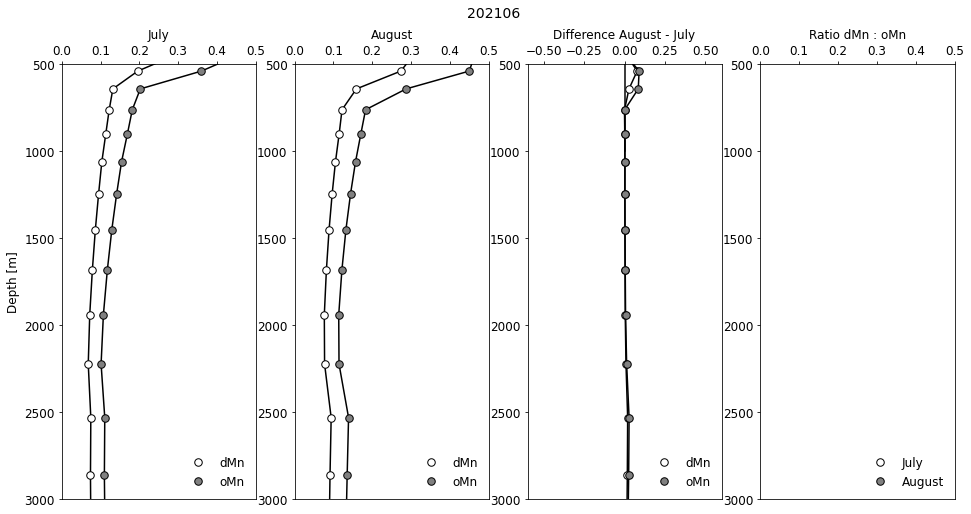

In [11]:
compare_profiles(dmn_jul, omn_jul, dmn_aug, omn_aug, '202106')

# Recreate August profile starting from the July profile:

In [8]:
timestepsize = 10 # seconds
n_steps = int(1.0*30*24*3600 / timestepsize) # Number of time steps in one month/

In [20]:
def fctn_scavenging(dMn, oMn, kred_pho):
    
    k_ox         = 7.00e-7 # oxidation constant (s-1)
    k_red        = 4.72e-7 # reduction constant (s-1)
    
    ddMn_dt = np.zeros_like(dMn)
    doMn_dt = np.zeros_like(oMn)
    
    # Photoreduction near the surface (upper 10 depth levels, or 13.5 m)
    ddMn_dt[0:10] = -dMn[0:10]*k_ox + oMn[0:10]*k_red*kred_pho
    doMn_dt[0:10] = dMn[0:10]*k_ox - oMn[0:10]*k_red*kred_pho

    # Reduction everywhere else
    ddMn_dt[10:] = -dMn[10:]*k_ox + oMn[10:]*k_red
    doMn_dt[10:] = dMn[10:]*k_ox - oMn[10:]*k_red

    return ddMn_dt, doMn_dt

In [21]:
def fctn_sinking(oMn, depth):
    
    # Sinking speed default as 1 m/day
    s_ox = 0.6*np.ones_like(depth) / (3600*24)

    MLD = 20 # Mixed layer depth
    e3t_0 = e3t[:,0,0] # grid box thicknesses
    
    doMn_dz = np.zeros_like(depth) # initialize vertical derivative as zero
    for k, depth in enumerate(depth):
#         if depth < 2500:
#             zfact = (depth - MLD) / 2500
#         else:
#             zfact = 1.0
        
#         # sinking speed increases up to a max of 10 m / day for high particulate concentrations
#         if oMn[k] > 0.45:
#             s_ox[k] = (1.0 + 9.0*max(0,zfact)) / (3600*24)
            
        # difference scheme for calculating vertical derivative of concentrations:
        if (k==0):
            doMn_dz[k] = s_ox[k]*oMn[k] / e3t_0[k]
        else:
            doMn_dz[k] = (s_ox[k]*oMn[k] - s_ox[k-1]*oMn[k-1]) / e3t_0[k]
            
    # Calculate the amount of oMn that sinks this time step
    doMn_dt = -doMn_dz #np.multiply(s_ox, doMn_dz)
    
    return doMn_dt

In [22]:
def move_forward(dMn, oMn, sedice, kred_pho, depth=depth, sinking=True):
    
    # Array to store profiles in
    dMn_profiles = np.empty((n_steps, 50))
    oMn_profiles = np.empty((n_steps, 50))

    # Loop over the timesteps
    for t in range(0, n_steps):
        # Call the source/sink functions
        if sinking:
            doMn_dt_sink = fctn_sinking(oMn, depth)
        else:
            doMn_dt_sink = np.zeros_like(oMn)
            
        # Surface input from sediment in sea ice:
        ddMn_dt_ice    = np.zeros_like(dMn)
        ddMn_dt_ice[0] = sedice # moles / L / s

        # Scavenging:
        ddMn_dt_scav, doMn_dt_scav = fctn_scavenging(dMn, oMn, kred_pho)

        # Sum the rates of change           
        ddMn_dt = np.add(ddMn_dt_scav, ddMn_dt_ice)
        doMn_dt = np.add(doMn_dt_scav, doMn_dt_sink)

        # Apply rate of change to timestep
        dMn = np.add(dMn, ddMn_dt*timestepsize)
        oMn = np.add(oMn, doMn_dt*timestepsize)

        dMn_profiles[t,:] = dMn
        oMn_profiles[t,:] = oMn
    
    return dMn_profiles, oMn_profiles

In [23]:
dMn_forward, oMn_forward = move_forward(dmn_jul, omn_jul, dmn_sed_ice_aug, kred_pho_aug)
dMn_forward_nosink, oMn_forward_nosink = move_forward(dmn_jul, omn_jul, dmn_sed_ice_aug, kred_pho_aug, sinking=False)

In [36]:
def forward_profiles(dmn_jul, dmn_aug, dMn_forward, omn_jul, omn_aug, oMn_forward, run_name, zoom=False, save=False):
    
    fig, ax = plt.subplots(1,3, figsize=(12,5))
    
#     fig.suptitle(run_name,fontsize=14)

    ax[0].set_title('Dissolved Mn', fontsize=12)
    ax[0].plot(dmn_jul, depth, '--k', label='Initial profile')
    ax[0].plot(dmn_aug, depth, '-k')
    ax[0].plot(dmn_aug, depth, '.w', markersize=15, markeredgecolor='k', label='Fortran result')
    ax[0].plot(dMn_forward, depth, '-k')
    ax[0].plot(dMn_forward, depth, '.r', markersize=15, markeredgecolor='k', label='Python estimate')

    ax[1].set_title('Oxidised Mn', fontsize=12)
    ax[1].plot(omn_jul, depth, '--k')
    ax[1].plot(omn_aug, depth, '-k')
    ax[1].plot(omn_aug, depth, '.w', markersize=15, markeredgecolor='k', label='Fortran result')
    ax[1].plot(oMn_forward, depth, '-k')
    ax[1].plot(oMn_forward, depth, '.r', markersize=15, markeredgecolor='k', label='Python estimate')
    
    ax[2].set_title('Fortran minus Python estimate', fontsize=12)
    ax[2].plot([0, 0], [600, 0], '-k')
    ax[2].plot(dmn_aug - dMn_forward, depth, '-k')
    ax[2].plot(dmn_aug - dMn_forward, depth, '.w', markersize=15, markeredgecolor='k', label='dMn')
    ax[2].plot(omn_aug - oMn_forward, depth, '-k')
    ax[2].plot(omn_aug - oMn_forward, depth, '.', c='gray', markersize=15, markeredgecolor='k', label='oMn')

    ax[0].set_ylabel('Depth [m]', fontsize=12)

    for axis in ax.ravel():
        axis.invert_yaxis()
        axis.set_xlim(0,2)
        if zoom:
            axis.set_ylim(50,0)
        else:
            axis.set_ylim(300,0)
        axis.tick_params(axis='both', labelsize=12)
        axis.xaxis.tick_top()    
        axis.xaxis.set_label_position('top') 
    
    ax[2].set_xlim(-0.6,0.6);
    
    ax[0].legend(fontsize=12, loc=4)
    ax[2].legend(fontsize=12, loc=3)
    
    if save:
        fig.savefig(f'/ocean/brogalla/GEOTRACES/figures/{run_name}.png', bbox_inches='tight')
    
    return

#### Profiles from 202106 reference run:

In [37]:
print('202106 --- average difference of concentrations in August from reference run compared to estimated here')
print('(ignoring anything shallower than 30 m)')
print(f'dissolved Mn with sinking: {np.average(dmn_aug[15:] - dMn_forward[-1,15:]):12.2e}')
print(f'dissolved Mn without sinking: {np.average(dmn_aug[15:] - dMn_forward_nosink[-1,15:]):9.2e}')
print(f'oxidised Mn with sinking: {np.average(omn_aug[15:] - oMn_forward[-1,15:]):13.2e}')
print(f'oxidised Mn without sinking: {np.average(omn_aug[15:] - oMn_forward_nosink[-1,15:]):10.2e}')

202106 --- average difference of concentrations in August from reference run compared to estimated here
(ignoring anything shallower than 30 m)
dissolved Mn with sinking:     7.08e-03
dissolved Mn without sinking: -1.55e-03
oxidised Mn with sinking:      1.15e-02
oxidised Mn without sinking:  -1.14e-02


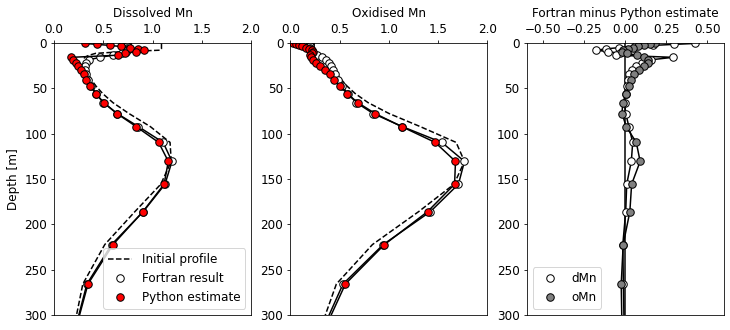

In [38]:
forward_profiles(dmn_jul, dmn_aug, dMn_forward[-1,:], omn_jul, omn_aug, oMn_forward[-1,:], 'normal_sinking', save=False)

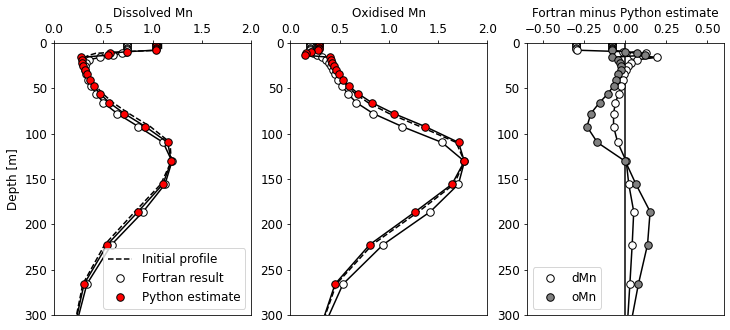

In [39]:
forward_profiles(dmn_jul, dmn_aug, dMn_forward_nosink[-1,:], omn_jul, omn_aug, oMn_forward_nosink[-1,:], 'no_sinking', save=False)

# Test simple sinking:

In [36]:
def simple_fctn_sinking(oMn, depth):

    # Parameters:
    s_ox = np.ones_like(depth) / (3600*24) # sinking speed default as 1 m/day --> 1 m/s
    e3t_0 = e3t[:,0,0] # grid box thicknesses
    
    doMn_dz = np.zeros_like(depth) # initialize vertical derivative as zero
    for k, depth in enumerate(depth):
        # difference scheme for calculating vertical derivative of concentrations:
        if (k==0): # at ocean surface
            doMn_dz[k] = oMn[k] / e3t_0[k]
        else:
            doMn_dz[k] = (oMn[k] - oMn[k-1]) / e3t_0[k]
            
    # Calculate the amount of oMn that sinks this time step
    doMn_dt = -np.multiply(s_ox, doMn_dz)
    
    return doMn_dt

In [97]:
def step_forward(oMn, depth=depth):
    
    # Array to store profiles in
    oMn_profiles = np.empty((n_steps, 50))

    # Loop over the timesteps
    for t in range(0, n_steps):
        # Call the source/sink functions
        doMn_dt_sink = simple_fctn_sinking(oMn, depth)

        oMn = np.add(oMn, doMn_dt_sink*timestepsize)

        oMn_profiles[t,:] = oMn
    
    return oMn_profiles

In [98]:
omn_initial = 5*np.exp(-((depth-100)/50)**2)

In [99]:
oMn_forward = step_forward(omn_initial)

Text(0, 0.5, 'Depth [m]')

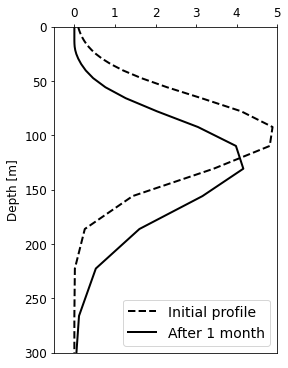

In [100]:
fig, ax = plt.subplots(1,1, figsize=(4,6))

ax.plot(omn_initial, depth, '--k', label='Initial profile', linewidth=2.0)
ax.plot(oMn_forward[-1,:], depth, '-k', label='After 1 month', linewidth=2.0)

ax.invert_yaxis()
ax.set_xlim(-0.5,5)
ax.set_ylim(300,0)
ax.tick_params(axis='both', labelsize=12)
ax.xaxis.tick_top()    
ax.xaxis.set_label_position('top') 
ax.legend(fontsize=14, loc=4)
ax.set_ylabel('Depth [m]', fontsize=12)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/sinking_bulge.png', bbox_inches='tight')